# Transfer Learning with BERT and other Pre-Trained Language Models

**Prepared for LLM workshop at WashU**

**Ishita Gopal**


[Note: we probably won't run all these code blocks live in class, as the fine-tuning steps together take about 30+ minutes to run.]

## Setup -- Installations

In [ ]:
%%capture
#!pip install accelerate -U

In [ ]:
#!pip install ipywidgets==7.7.2


In [ ]:
%%capture
#!pip install nltk
#!pip install datasets
#!pip install transformers

Import required packages, make sure Colab is set up to use a GPU. (You *really* want GPU acceleration for training or fine-tuning transformer models. They theoretically can train on CPU only, but it could take days due to the huge number of trainable parameters.)

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

print("Version: ", torch.__version__)
print("Eager mode: ", torch.backends.cudnn.enabled)
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")


Version:  2.2.1+cu121
Eager mode:  True
GPU is available


In [2]:
from transformers import set_seed
import random

# Set seeds for reproducibility
def set_seeds(seed: int):
    random.seed(seed)               # Python's built-in random number generator
    np.random.seed(seed)            # NumPy's random number generator
    torch.manual_seed(seed)         # PyTorch's manual seed for CPU
    torch.cuda.manual_seed_all(seed)  # PyTorch's manual seed for all GPUs
    set_seed(seed)                  # Hugging Face's set_seed for Transformers library

set_seeds(10)

# **A bit about the `transformers` libray**

 The Hugging Face `transformers` is a package for Python that has become one of the essential tools for NLP transfer learning in Python. `transformers` should be combined with a deep learning library like, Pytorch or TensorFlow and these would need to be installed on your machine. (You don't have to install them in Collab because it comes with it)





## **Pipeline**

Let's look at the Huggingface website: https://huggingface.co/docs/transformers/main_classes/pipelines

The `pipeline` function from the Hugging Face `transformers` library is a high-level utility that abstracts away much of the complexity of working with pre-trained models for various natural language processing (NLP) tasks.
Here's all of the things the `pipeline` function is doing:

1. **Loading a pre-trained model**: When you specify a task (e.g., "sentiment-analysis") as an argument to the pipeline function, it automatically loads a pre-trained model that has been fine-tuned for that specific task. Hugging Face provides a wide range of pre-trained models for different NLP tasks.

2. **Tokenization and processing**: Once the model is loaded, the input text is tokenized and preprocessed according to the requirements of the specific task. This includes tasks such as adding special tokens, padding sequences, and preparing the input in the appropriate format for the model.

3. **Model inference**: The preprocessed input is then passed through the loaded model to generate predictions or perform the specified task. For sentiment analysis, the model predicts the sentiment label (e.g., positive, negative) of the input text.

4. **Post-processing**: After the model generates predictions, the pipeline function may perform additional post-processing steps, such as converting model outputs into human-readable formats or applying thresholding to confidence scores.


In [3]:
# Importing the pipeline function from the transformers library
from transformers import pipeline


In [4]:
# Creating a sentiment analysis pipeline
classifier = pipeline("sentiment-analysis")
#classifier = pipeline("text-classification") # both will produce the same result

# Analyzing the sentiment of the input text
# To call a pipeline on many items, you can call it with a list.
res = classifier(["I love HuggingFace!",
                  "The food at the cafe in the library is not that great :("])

# Printing the result
print(res)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998130202293396}, {'label': 'NEGATIVE', 'score': 0.9996552467346191}]


There are a lot more tasks available. Lets look at a text generation pipeline:

Let's try another one: zero shot classification

In [36]:
zero_classifier = pipeline("zero-shot-classification")
zero_classifier(
    "This is a course about LLMs and transfer learning",
    candidate_labels = ["education", "sports", "politics"]
    )

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'This is a course about LLMs and transfer learning',
 'labels': ['education', 'sports', 'politics'],
 'scores': [0.979352593421936, 0.011407848447561264, 0.0092394994571805]}

## **Class Exercise**:

Complete the following tasks:

1. Translate the following text in French to English: "quel âge êtes-vous?" Find the appropriate pipeline here https://huggingface.co/docs/transformers/v4.39.0/en/task_summary#translation

2. Find all the named entities in this sentence: "Hugging Face is a French company based in New York City."
refer to this page to find the appropriate pipeline for named entity recognition: https://huggingface.co/docs/transformers/v4.39.0/en/main_classes/pipelines

In [37]:
#classifier = pipeline(task="ner")
#preds = classifier("Hugging Face is a French company based in New York City.")
#preds

Lets look at the models on huggingface: https://huggingface.co/models

# **Text Classification with DistilBERT**

In this section, we will delve into text classification using pre-trained Transformer language models, focusing on adapting them to a movie review dataset. We will explore how to leverage massive pre-trained models like Hugging Face's DistilBERT (Sanh et al., 2019) and Google's BERT base uncased (Devlin et al., 2018) for text classification tasks. Specifically, our objective is to categorize movie reviews as either positive or negative sentiments. We'll discuss the fine-tuning process, where we adjust the parameters of the pre-trained models to suit our specific classification task.

Instead of using `pipelines` for training and fine-tuning pre-trained Transformer models, we'll work directly with the underlying model classes and training procedures. Essentially, we will look behind the pipeline and understand the steps a bit better. While `pipelines` offer a convenient way to perform inference tasks using pre-trained models, they are not suitable for training new models or fine-tuning existing ones due to their focus on simplicity, efficiency, and limited flexibility. For training tasks, direct interaction with the underlying model classes and training procedures is necessary.

## **Let's Load the Data**

Let's load our IMDB movie reviews dataset. For this demo, we're going to load the data from a CSV file, as that more closely represents common practices for  applications. We will use a fraction (10%) of the dataset for demonstration to make training faster and use less resources.

In [5]:
# Load the IMDb dataset from the provided URL
imdb = pd.read_csv("https://github.com/bestvater/misc/raw/master/IMDB%20Dataset.csv")

# Replace the 'sentiment' column values with 1 for 'positive' and 0 for 'negative'
imdb['sentiment'].replace(to_replace = {'positive':1, 'negative':0}, inplace = True)

# Sample a fraction of the dataset (10%) with a specified random state for reproducibility
# This is just to reduce the time needed for training
imdb = imdb.sample(frac = .1, random_state=101).reset_index(drop = True)


/tmp/ipykernel_4858/3972082068.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imdb['sentiment'].replace(to_replace = {'positive':1, 'negative':0}, inplace = True)
/tmp/ipykernel_4858/3972082068.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imdb['sentiment'].replace(to_replace = {'positive

In [6]:
imdb.shape

(5000, 2)

In [7]:
imdb.sentiment.value_counts() # looks balanced

sentiment
1    2614
0    2386
Name: count, dtype: int64

## **Create Train, Val, Test Splits**

We will randomly split the entire training data into two sets: a train set with 80% of the data, a validation set with 10% of the data and a test set with 10% of the data .




In [8]:
from sklearn.model_selection import train_test_split

# Split dataset into training and remaining data
train_data, remaining_data = train_test_split(imdb, test_size=0.2, stratify=imdb['sentiment'], random_state=42)

# Split remaining data into validation and test sets
val_data, test_data = train_test_split(remaining_data, test_size=0.5, stratify=remaining_data['sentiment'], random_state=42)

# Print sizes of each set
print("Train set size:", train_data.shape)
print("Validation set size:", val_data.shape)
print("Test set size:", test_data.shape)

Train set size: (4000, 2)
Validation set size: (500, 2)
Test set size: (500, 2)


## **Baseline: Naive Bayes Classifier**
We will use the Naive bayes as the baseline to compare DisttilBert's Performance.

In the implmentation below, will vectorize our text data to create a document term matrix. We will then use the Naive Bayes model as our baseline classifier. We can fit other models (SVM, Random Forest, XGBoost etc.) as well and we can use different forms of the features (Tf-idf etc.). I just have not done that here.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
nltk.download('punkt')
import numpy as np


[nltk_data] Downloading package punkt to /home/gopali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:

# Naive Bayes
# Create a CountVectorizer instance for feature extraction
vectorizer = CountVectorizer(tokenizer=word_tokenize, binary=True)

# Convert the text data into a document-term matrix
X_train_dtm = vectorizer.fit_transform(train_data["review"])
X_test_dtm = vectorizer.transform(test_data["review"])

# Create an instance of the Naive Bayes classifier
nb_classifier = BernoulliNB()

# Train (fit) the classifier using the training data
nb_classifier.fit(X_train_dtm, train_data["sentiment"])
predictions_nb = nb_classifier.predict(X_test_dtm)
# Evaluate the classifier
accuracy = accuracy_score(test_data["sentiment"], predictions_nb)
print(f'Accuracy: {accuracy:.2f}')

/home/gopali/anaconda3/envs/llm_workshop_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.85


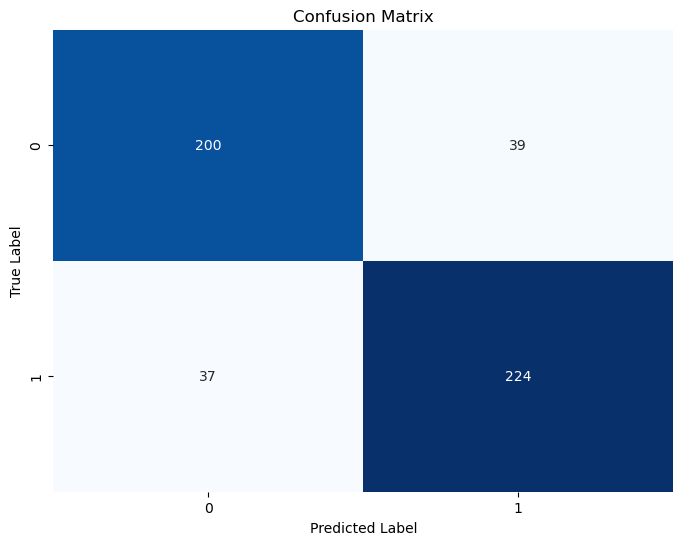

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(test_data["sentiment"], predictions_nb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Load Libreries to work with DistilBERT**

Now we will get our first introduction to the `transformers` package. We're going to load in two functions, `AutoTokenizer` and `AutoModelFromSequenceClassification`. Let's load them first and then talk about what they do.

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## **AutoTokenizer for DistilBERT Tokenization**

Neural network can't read raw texts as inputs--those texts need to be tokenized before they can be understood.

**When we're working with a neural network built from scratch**: there's a lot of flexibility in how we tokenize--we could use counts of words, one-hot representations of words, dense embeddings, character-level representations, etc. We can set the vocabulary size, or embedding dimension to whatever we wish.


**But when we're working with a pre-trained model**, we don't have that kind of flexibility. The model expects to see inputs in the specific format that matches the inputs it was initially trained on. The easiest way to ensure that new inputs match that format is to use the same tokenizer as the model used during pre-training. Repositories like Hugging Face know this, so they provide approprate tokenizers alongside the pre-trained models they host.

**The `AutoTokenizer.from_pretrained()` method** takes a valid pretrained model name from the Hugging Face repository as an argument, and returns the tokenizer appropriate to that model.

Here, we are using the DistilBERT model. It uses "distilation" to reduce the number of parameters of the pretrained BERT-base model while maintaining most of its performance. DistilBERT is more lightweight than BERT and should train faster.

Like BERT, DistilBERT's tokenizer uses a variation of [word-piece tokenization](https://huggingface.co/docs/transformers/v4.39.0/en/tokenizer_summary#wordpiece), and truncates input sequences to 512 tokens, so that's the maxium length available for input documents with DistilBERT. However, you can use the `model_max_length` argument to specify a shorter length if desired. For example we could use 256-token inputs or 128-token inputs etc., as the network can process the shorter documents faster.'

In [13]:
# Make an instence of the AutoTokenizer class and pass in the model whose tokenizer we want to use
# In this case it is DistilBert
# https://huggingface.co/distilbert/distilbert-base-uncased#how-to-use
model_name = 'distilbert-base-uncased'
DistilBERT_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length = 512)


Now that we have the tokenizer, we'll apply it to the training, test, and validation documents.

## **Lets look at an example to understand what the tokenizer does:**

In [14]:
# Here is some example text (the first review in our training data)
example_review = train_data["review"][0]
example_review

"I don't know what it is about the crew from CKY, but everything they produce seems to be genius in its simplicity and stupidity. Haggard is so incredibly dumb and funny that it's almost comedic excellence. Sometimes it makes absolutely no sense, but who cares?<br /><br />It made me laugh my ass off. A must-have for the CKY/Jackass aficionado!"

### What arguments are passed?
The `padding` argument tells the tokenizer to pad out documents less than the model's max length, which in this case we set to 256, and the `trucation` argument tells it to cut off documents longer than 256. The `return_tensors` argument tells it what format to use when returning the tokenized texts--'tf' for TensorFlow, 'pt' for Pytorch.


In [15]:
# Apply the BERT tokenizer
# - example_review: Input text or list of texts to be tokenized
# - padding: Whether to pad sequences to the same length (here, 'max_length')
# - truncation: Whether to truncate sequences longer than the specified maximum length
# - return_tensors: Format of the returned tensors ('pt' for PyTorch tensors)
example_tokens = DistilBERT_tokenizer(example_review,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')


example_tokens

{'input_ids': tensor([[  101,  1045,  2123,  1005,  1056,  2113,  2054,  2009,  2003,  2055,
          1996,  3626,  2013, 23616,  2100,  1010,  2021,  2673,  2027,  3965,
          3849,  2000,  2022, 11067,  1999,  2049, 17839,  1998, 28072,  1012,
         27912,  2003,  2061, 11757, 12873,  1998,  6057,  2008,  2009,  1005,
          1055,  2471, 21699,  8012,  1012,  2823,  2009,  3084,  7078,  2053,
          3168,  1010,  2021,  2040, 14977,  1029,  1026,  7987,  1013,  1028,
          1026,  7987,  1013,  1028,  2009,  2081,  2033,  4756,  2026,  4632,
          2125,  1012,  1037,  2442,  1011,  2031,  2005,  1996, 23616,  2100,
          1013,  2990, 12054, 28697, 10446,  9365,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [16]:
# We can check the number of tokens generated and confirm it is 512
example_tokens["input_ids"].size()

torch.Size([1, 512])

In [17]:
# See which tokens corresponds to which index
# Get tokens
tokens = DistilBERT_tokenizer.tokenize(example_review)
print("Tokens:", tokens)

# Get token ids
ids = DistilBERT_tokenizer.convert_tokens_to_ids(tokens)
print("Input IDs:", ids)

# Decode string
decoded_string = DistilBERT_tokenizer.decode(ids)
print("Decoded string:", decoded_string)


Tokens: ['i', 'don', "'", 't', 'know', 'what', 'it', 'is', 'about', 'the', 'crew', 'from', 'ck', '##y', ',', 'but', 'everything', 'they', 'produce', 'seems', 'to', 'be', 'genius', 'in', 'its', 'simplicity', 'and', 'stupidity', '.', 'haggard', 'is', 'so', 'incredibly', 'dumb', 'and', 'funny', 'that', 'it', "'", 's', 'almost', 'comedic', 'excellence', '.', 'sometimes', 'it', 'makes', 'absolutely', 'no', 'sense', ',', 'but', 'who', 'cares', '?', '<', 'br', '/', '>', '<', 'br', '/', '>', 'it', 'made', 'me', 'laugh', 'my', 'ass', 'off', '.', 'a', 'must', '-', 'have', 'for', 'the', 'ck', '##y', '/', 'jack', '##ass', 'afi', '##cion', '##ado', '!']
Input IDs: [1045, 2123, 1005, 1056, 2113, 2054, 2009, 2003, 2055, 1996, 3626, 2013, 23616, 2100, 1010, 2021, 2673, 2027, 3965, 3849, 2000, 2022, 11067, 1999, 2049, 17839, 1998, 28072, 1012, 27912, 2003, 2061, 11757, 12873, 1998, 6057, 2008, 2009, 1005, 1055, 2471, 21699, 8012, 1012, 2823, 2009, 3084, 7078, 2053, 3168, 1010, 2021, 2040, 14977, 1029, 

 ### What is returned?
Calling the tokenizer typically returns a **dictionary** containing **various tokenized representations** of the input text (just like above). The specific keys and their meanings depend on the tokenizer used and the options specified.

However, common keys that are often returned in the tokens dictionary include:

**`input_ids`:** This key contains the token IDs representing the input text. Each token in the input text is replaced with its corresponding token ID from the tokenizer's vocabulary. The zeros represent special tokens such as padding tokens/[PAD] token. When tokenizing sequences of varying lengths, shorter sequences are padded with this special token to match the desired input length.

For example, if your input sequence is [CLS] tokenized text [SEP], where [CLS] and [SEP] are special tokens indicating the beginning and end of a sequence, and tokenized text is your actual text tokenized into individual tokens, then the input_ids array might look like this:

```
array([[ 101, token1_id, token2_id, ..., tokenN_id, 102, 0, 0, ..., 0]])

```

These padding tokens ensure that all input sequences have the same length, which is necessary for efficient processing in neural networks. During training and inference, the model typically ignores the padded parts of the input sequence, focusing only on the relevant tokens.

(They represent the input to the model and are used to look up the corresponding embeddings for each token in the embedding matrix.)

**`attention_mask`:** This key contains the attention mask, which indicates which tokens are actual words in the input text and which are padding tokens. It is used to distinguish real tokens from padding tokens. It has the same length as the 'input_ids' and has a value of 1 for real tokens and 0 for padding tokens.

**Other keys** might include 'token_type_ids' for models that use token type IDs (e.g., BERT for sentence-pair tasks), or additional special tokens like 'special_tokens_mask', 'overflowing_tokens', etc., depending on the tokenizer and the specific tokenization options used.

## **Create a huggingface dataset:**

You can find more information about datasets [Hugging Face's documentation](https://huggingface.co/docs/datasets/v1.13.1/use_dataset.html)
These HF viodeo tutorials [[1](https://www.youtube.com/watch?v=_BZearw7f0w&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&index=20), [2](https://www.youtube.com/watch?v=blF9uxYcKHo)] are also helpful.


In [18]:
from datasets import Dataset, DatasetDict, load_from_disk

hf_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'val': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

In [19]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', '__index_level_0__'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['review', 'sentiment', '__index_level_0__'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment', '__index_level_0__'],
        num_rows: 500
    })
})

In [20]:
# Tokenize and encode the entire text column using DistilBERT tokenizer
def tokenize_data(example):
    encoded = DistilBERT_tokenizer(
        example['review'],
        padding='max_length',  # Pad sequences to maximum length
        truncation=True,  # Truncate sequences longer than max_length
        max_length=512)  # Maximum sequence length

    return encoded

# Apply the tokenize_data function to each batch of the hf_dataset
# batched=True allows for parallel processing of multiple examples at once
# improving processing speed and efficiency, especially when dealing with large datasets
hf_dataset = hf_dataset.map(tokenize_data, batched=True)

print(hf_dataset)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['review', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})


In [21]:
hf_dataset = hf_dataset.rename_column("sentiment","labels")
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [22]:
# print columns names
print(hf_dataset.column_names)

{'train': ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'], 'val': ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'], 'test': ['review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask']}


In [23]:
# set the output format to torch (you can also use tensorflow/numpy)
hf_dataset = hf_dataset.with_format(type='torch')

In [24]:
# Check that outputs are torch tensors
print(isinstance(hf_dataset["train"][0]["input_ids"], torch.Tensor))
print(isinstance(hf_dataset["train"][0]["attention_mask"], torch.Tensor))
print(isinstance(hf_dataset["train"][0]["labels"], torch.Tensor))


True
True
True


## **AutoModel to Set Up BERT**

Now that we have a tokenizer sorted, let's actually download our pre-trained DistilBERT model. For this, we'll use another `transformers` function: `AutoModelForSequenceClassification`. 'AutoModel' means it's going to take the model name as an input, like with the `AutoTokenizer`, and determine what the we're looking for without us having to specify, and the 'ForSequenceClassification' tells the library what "head," or output layer, we want on the model.

The `num_labels` parameter specifies the number of labels for the classification task. In this case, num_labels=2 indicates that the model will be used for binary classification, where there is only one output label.

Once downloaded, we can look at the model summary.

In [25]:
# Make an instence of the AutoModelForSequenceClassification class and pass the model name and number of labels
# Download pre-trained BERT model as PyTorch with two labels in the output layer
DistilBERT_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Print model summary
print(DistilBERT_model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [26]:
# Calculate the number of parameters in the model
num_params = DistilBERT_model.num_parameters()

# Print the number of parameters
print("Number of parameters in the DistilBERT model:", num_params)

Number of parameters in the DistilBERT model: 66955010


## **Class Exercise:**
Go to https://huggingface.co/models and find the bert-base-uncased model. Can you find it?

Also download this model using the AutoModelForSequenceClassification function in the code block below and print the model summary. How many more parameters does it have as compared to DistilBERT?


## **Fine Tune [DistilBERT](https://huggingface.co/docs/transformers/en/tasks/sequence_classification) model:**
Summary of what this does:
Fine-tuning involves updating the parameters of the pre-trained model using a task-specific dataset, which typically consists of labeled examples relevant to the target task. Here's what happens when we fine-tune DistilBERT or BERT:

1.**Task-specific Adaptation**: The pre-trained DistilBERT or BERT model has already learned general language representations from a large corpus of text. During fine-tuning, we adjust its parameters to adapt these representations to the nuances of the target task. This adaptation process helps the model capture task-specific patterns and features that are important for achieving good performance on the task.

2. **Gradient-based Optimization**: Fine-tuning involves optimizing the model's parameters based on gradients computed from the task-specific dataset. We use optimization algorithms such as stochastic gradient descent (SGD) or Adam to update the parameters iteratively, minimizing a loss function that measures the disparity between the model's predictions and the ground truth labels in the training data.

3. **Transfer of Knowledge**: Fine-tuning leverages the knowledge encoded in the pre-trained model to expedite learning on the target task. By starting with pre-trained parameters that have already captured a rich understanding of the language, the model requires fewer labeled examples and less training time to achieve good performance on the downstream task compared to training from scratch.

4. **Regularization and Generalization**: Fine-tuning helps prevent overfitting by regularizing the model's parameters during training. By starting with pre-trained parameters that generalize well across diverse language tasks, fine-tuning encourages the model to learn task-specific features while retaining its ability to generalize to unseen data.

5. **Task-specific Head**: In addition to fine-tuning the pre-trained layers of DistilBERT or BERT, we often add a task-specific classification head on top of the model. This head consists of one or more additional layers that map the model's contextualized representations to the number of output classes relevant to the target task, such as positive/negative labels for sentiment analysis.

Overall, fine-tuning DistilBERT or BERT enables us to adapt these powerful pre-trained language models to a wide range of NLP tasks with relatively little labeled data and computational resources, while still achieving state-of-the-art performance.

### **The TrainerArguments and Trainer class:**
The Trainer class provides an API for feature-complete training in PyTorch.  Trainer goes hand-in-hand with the TrainingArguments class, which offers a wide range of options to customize how a model is trained. Together, these two classes provide a complete training API (from [documentation](https://huggingface.co/docs/transformers/v4.39.1/en/main_classes/trainer#transformers.Trainer)).

<img src="https://github.com/IshitaGopal/TRIADS_workshops/raw/main/llm_workshop/pics/Trainer_API.png"  width="1000">




### **Before creating the Trainer:**

- We will define our model (*we already did this when we instantiated the DistilBert model above*) and some training hyperparameter.

- We will also need a path to a folder where results and checkpoints will be saved.

- We can customize all the hyperparamneters the Trainer will use such as the learning rate, number of training epochs etc.

- We can also define a `compute_metrics` function to monitor the evaluation metrics during training. The predictions on the whole evaluation set are gathered. This function takes a named tuple (produced by the model) with predictions and labels and then returns a dictionary with the metric/metrics we want to keep track of (These can be accuracy, precision , F1 etc.). Note that the predictions returned by the model are logits of the model which we further need to process to get meaningful results. We do this in the `compute metrics function` defined below.

- We can pass the epoch evaluation strategy to our TrainingArgument to tell the Trainer to evaluate the model at then end of every epoch (on the validation data we pass). When training is lauched, it will create a table and create a row with metrics after every epoch.

### **Some Notes:**

1. When creating our dataset, we do not need to remove/rename columns or set the format to torch tensors as the Trainer will do all of this automatically by analyzing the model signature. (A model's signature refers to a description or specification of the model's inputs, outputs, and any additional information necessary to understand how the model operates.)

2. **Hyperparameter** in the context of machine learning are parameters that are set before the learning process begins. They control aspects of the learning process and directly influence the performance of the model but are not learned from the data.

3. **Checkpoint** refers to a snapshot of the model's parameters (weights and biases) at a specific point in time during training. These checkpoints are saved periodically during the training process and serve several purposes:

  1. **Resuming Training:** If the training process is interrupted (e.g., due to a system failure or reaching the maximum training duration), you can resume training from the most recent checkpoint rather than starting from scratch.
  2. **Model Evaluation:** provide a means to evaluate the model's performance on a validation or test dataset at different stages of training. By loading a checkpoint, you can assess how the model's performance has evolved over time
  3. **Model Deployment:** used when deploying machine learning models into production environments. By saving the final trained model as a checkpoint, you can load it into inference systems for making predictions on new data without needing to retrain the model from scratch.

4. The Trainer saves models based on the validation loss. It monitors the validation loss, and if it improves compared to the previous best (i.e., decreases for minimizing loss), the Trainer saves the model checkpoint. You can customize this behavior by specifying the metric_for_best_model argument. This argument allows you to specify which metric to use for saving the best model checkpoint. For example, if you want to save based on accuracy instead of loss, you would set metric_for_best_model="accuracy". With this setup, the Trainer will save the model checkpoint based on the accuracy metric computed by the compute_metrics function.

### **Define the `compute_metrics` function:**
Here we are taking the logits and labels provided by the model as input and computing probabilities using the softmax function, getting the class predictions and then computing 3 metrics we want to track -  we are calculating the accuracy, precision and recall.

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define a function to calculate accuracy, precision, and recall for the model.
def compute_metrics(eval_pred):
    logits, labels = eval_pred # Unpack the evaluation predictions
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True) # Compute probabilities using softmax
    preds = np.argmax(probabilities, axis=1) # Predictions are the class with the highest probability

    # Compute accuracy, precision, and recall
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, pos_label=1)
    recall = recall_score(labels, preds, pos_label=1)

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }


### **Define Callbacks:**

In the Hugging Face library, TrainerCallbacks are components that allow users to customize and extend the behavior of the Trainer class during training. They provide "hooks" at different stages of the training process, allowing users to execute custom code before, during, or after specific events, such as the start or end of an epoch, the beginning or completion of a training step, or the evaluation of the model on validation data.

- Below, we are using the `on_evaluate` "hook" within the `AccuracyCallback` class. This hook is called during the evaluation phase of the training process, specifically after evaluating the model's performance on the validation dataset.
See more [here](https://huggingface.co/docs/transformers/en/main_classes/callback#transformers.TrainerCallback).

- The `AccuracyCallback` class tracks the accuracy metric during evaluation and saves the model only if it achieves a higher accuracy than the previous best. While the Trainer saves checkpoints periodically, it doesn't necessarily save the best-performing model based on accuracy.



In [28]:
from transformers import Trainer, TrainingArguments, TrainerCallback
class AccuracyCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0
        self.best_learning_rate = None
        self.best_seed = None

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        accuracy = metrics.get('eval_accuracy', 0)

        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.best_learning_rate = args.learning_rate
            self.best_seed = args.seed
            print(f"New best accuracy: {accuracy} at epoch {state.epoch}")


### **Define the Training Arguments:**

- We are defining the training arguments required for fine-tuning.
- These arguments include hyperparameters such as the learning rate, number of training epochs, and batch size for training data.
- We specify the evaluation strategy as "epoch," indicating that the model will be evaluated after each training epoch.
- We set the metric for best model to be 'accuracy', which means that the Trainer will save models based on the best evaluation accuracy computed by the compute_metrics function defined above. (metric_for_best_model: This parameter in the TrainingArguments specifies which evaluation metric the Trainer should use to determine the best model checkpoint for saving during training.)

Overall, these training arguments provide the necessary configurations for training and evaluating a model, as well as managing the outputs and logs generated during the training process.

In [32]:
# Define the training arguments for fine-tuning the model
training_args = TrainingArguments(
    learning_rate=5e-5,                 # Hyperparam: Set the learning rate for optimization
    num_train_epochs=3,                 # Hyperparam: Specify the number of training epochs
    per_device_train_batch_size=16,     # Hyperparam: Batch size for training data per GPU/device
    evaluation_strategy="epoch",        # Evaluate the model after each epoch
    save_strategy='epoch',
    metric_for_best_model='accuracy',   # Save models based on best evaluation accuracy (returned by compute_metrics function)
    load_best_model_at_end=True,        # Load the best model checkpoint at the end of training
    output_dir='my_awesome_model',      # Directory to save the trained model and other outputs and checkpoints
    logging_dir='logs'                 # Directory to save training logs such as loss and metrics
)

# Fine-tune the model on your dataset
# training_args = TrainingArguments(
#     learning_rate=5e-5,
#     output_dir='my_awesome_model',
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     num_train_epochs=3,
#     logging_dir='./logs',
#     evaluation_strategy="epoch",
#     save_total_limit=2,
# )


### **Defining the Trainer() and training:**

In [34]:
# Instantiate the AccuracyCallback to track training accuracy
accuracy_callback = AccuracyCallback()

# Define the Trainer with necessary configurations
trainer = Trainer(
    model=DistilBERT_model,                    # Specify the model architecture to be trained
    args=training_args,                        # Provide the training arguments
    train_dataset=hf_dataset["train"],         # Training dataset
    eval_dataset=hf_dataset["val"],            # Evaluation dataset for validation
    compute_metrics=compute_metrics,           # Function to compute evaluation metrics
    callbacks=[accuracy_callback]              # List of callbacks for additional actions during training
)

# Train the model using the defined Trainer
trainer.train()


/home/gopali/anaconda3/envs/llm_workshop_env/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/gopali/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,No log,0.212189,0.914000,0.907063,0.931298
2,No log,0.227307,0.912000,0.912879,0.919847
3,No log,0.301903,0.912000,0.922481,0.908397


New best accuracy: 0.914 at epoch 1.0


/home/gopali/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/gopali/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=375, training_loss=0.13964083862304688, metrics={'train_runtime': 92.67, 'train_samples_per_second': 129.492, 'train_steps_per_second': 4.047, 'total_flos': 1589608783872000.0, 'train_loss': 0.13964083862304688, 'epoch': 3.0})

In [35]:
# Evaluate the model (if needed)
results = trainer.evaluate()
results

/home/gopali/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.21218925714492798,
 'eval_accuracy': 0.914,
 'eval_precision': 0.9070631970260223,
 'eval_recall': 0.9312977099236641,
 'eval_runtime': 1.5096,
 'eval_samples_per_second': 331.204,
 'eval_steps_per_second': 21.197,
 'epoch': 3.0}

### **Evaluate the fine tuned model on the test set:**

In [36]:
# Define the threshold for predicting label 1
threshold = 0.5  # You can adjust this threshold as needed

# Make predictions on the test set
predictions = trainer.predict(hf_dataset["test"])

# Extract the probabilities for label 1
probabilities_1 = np.exp(predictions.predictions[:, 1]) / np.sum(np.exp(predictions.predictions), axis=1)

# Assign predictions based on the custom threshold
predicted_labels = (probabilities_1 >= threshold).astype(int)
true_labels = predictions.label_ids

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {accuracy:.4f}")



/home/gopali/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Accuracy: 0.9160


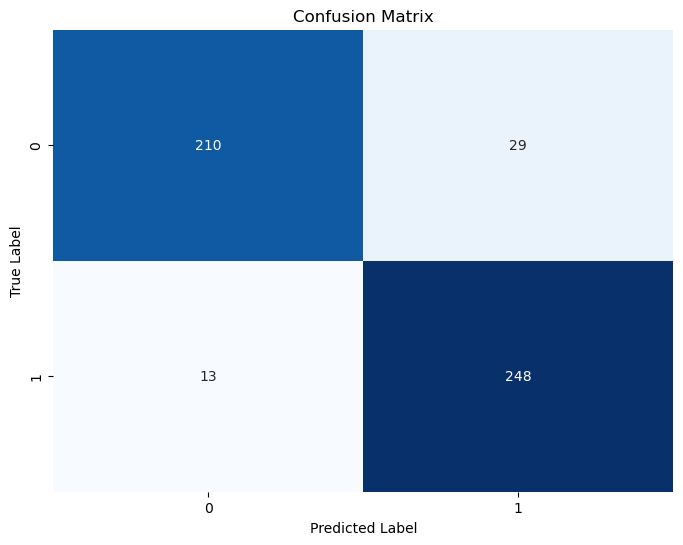

In [37]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## WIP: **Now lets perform hyperparamter tuning!**
## Need to add this

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
[I 2024-03-15 01:44:21,268] A new study created in memory with name: no-name-76251bfd-4006-4ce2-9097-ce7fb3393bbc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.124700,0.568818,0.868000,0.852518,0.904580
2,0.057800,0.741779,0.868000,0.871212,0.877863
3,0.039600,0.775404,0.862000,0.858736,0.881679


New best accuracy: 0.868 at epoch 1.0


Checkpoint destination directory results/run-0/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory results/run-0/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-15 01:50:19,066] Trial 0 finished with value: 2.602415448792531 and parameters: {'learning_rate': 5e-06, 'seed': 152}. Best is trial 0 with value: 2.602415448792531.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.073300,0.671801,0.864000,0.836806,0.919847
2,0.034200,0.891334,0.864000,0.867424,0.874046
3,0.017800,0.920091,0.864000,0.861940,0.881679


[I 2024-03-15 01:56:22,686] Trial 1 finished with value: 2.60761968782044 and parameters: {'learning_rate': 1e-05, 'seed': 239}. Best is trial 1 with value: 2.60761968782044.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.053300,0.951785,0.862000,0.858736,0.881679
2,0.023100,1.021856,0.852000,0.853383,0.866412
3,0.012100,1.023216,0.852000,0.850746,0.870229


[I 2024-03-15 02:02:12,931] Trial 2 finished with value: 2.572975276290304 and parameters: {'learning_rate': 1e-05, 'seed': 12}. Best is trial 1 with value: 2.60761968782044.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.087000,1.029743,0.852000,0.882114,0.828244
2,0.041400,1.048961,0.846000,0.838828,0.874046
3,0.011800,1.141604,0.842000,0.842697,0.858779


[I 2024-03-15 02:08:05,891] Trial 3 finished with value: 2.5434752551676816 and parameters: {'learning_rate': 2e-05, 'seed': 33}. Best is trial 1 with value: 2.60761968782044.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.073300,1.020262,0.860000,0.858209,0.877863
2,0.020500,1.074269,0.856000,0.880000,0.839695
3,0.006300,1.130260,0.862000,0.856089,0.885496


[I 2024-03-15 02:13:47,767] Trial 4 finished with value: 2.603584744091716 and parameters: {'learning_rate': 2e-05, 'seed': 796}. Best is trial 1 with value: 2.60761968782044.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.037400,1.107988,0.850000,0.850187,0.866412


[I 2024-03-15 02:15:35,729] Trial 5 pruned. 
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.023200,1.295006,0.856000,0.849265,0.881679


[I 2024-03-15 02:17:23,368] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.059400,0.911609,0.864000,0.808917,0.969466
2,0.016400,1.114764,0.868000,0.847518,0.912214
3,0.009700,1.097451,0.866000,0.862454,0.885496


[I 2024-03-15 02:23:36,427] Trial 7 finished with value: 2.61394971480462 and parameters: {'learning_rate': 2e-05, 'seed': 522}. Best is trial 7 with value: 2.61394971480462.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.018400,0.973628,0.874000,0.861818,0.904580
2,0.002000,1.110781,0.870000,0.855596,0.904580
3,0.004100,1.124903,0.870000,0.853047,0.908397


New best accuracy: 0.874 at epoch 1.0


[I 2024-03-15 02:29:32,911] Trial 8 finished with value: 2.631443541546964 and parameters: {'learning_rate': 5e-06, 'seed': 485}. Best is trial 8 with value: 2.631443541546964.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.017000,1.139372,0.868000,0.865672,0.885496


[I 2024-03-15 02:31:20,717] Trial 9 pruned. 


BestRun(run_id='8', objective=2.631443541546964, hyperparameters={'learning_rate': 5e-06, 'seed': 485}, run_summary=None)


## Train using the best hyperparameters:
## Todo:

In [ ]:
#API for developers
# CUDA - Pytorch - What is it?
# Nvidia GPU is required to use CUDA : https://www.youtube.com/watch?v=6stDhEA0wFQ
# With pytorch cuda comes baled in - We just need a supoorted Nvidia GPU
# We dont need to know how to use the cuda GPU directly
